## Data Exploration

In [ ]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
program_start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Started: '+ program_start_time)

### Load configuration

In [ ]:
"""
Loads common configuration parameters
"""
from src.utils.configuration_manager import Config
from pathlib import Path, PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = Config(config_path)

### Figures subdirectory

In [5]:
figures_dir = Path(config.figures_dir, 'data_exploration')
figures_dir.mkdir(parents=True, exist_ok=True)

### Start local Dask Client

In [6]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
    cluster = LocalCluster(dashboard_address=':20100', memory_limit='5G')
#     cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:45197' processes=5 threads=10, memory=25.00 GB>


Client Scheduler: tcp://127.0.0.1:45197 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 25.00 GB


### Prepare Dataset

In [7]:
"""
Loads the dataset file based on configuration 
"""
from src.preprocessing.dataset_manager import DatasetManager
dataset_manager = DatasetManager(config)

In [8]:
%time dataset_manager.write_dataset(overwrite=False)

Not overwriting existing training and test sets
CPU times: user 463 µs, sys: 96 µs, total: 559 µs
Wall time: 1.07 ms


In [9]:
ddf = dataset_manager.load_ddf()

In [10]:
ddf.npartitions

326

In [11]:
# ddf = ddf.repartition(npartitions=10000)

## Basic Data Statistics

In [12]:
ddf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount_wo_tip             float64
tip_fraction                    float64
tipped                             bool
dtype: object

In [13]:
%time ddf.describe().compute()

CPU times: user 40.3 s, sys: 3 s, total: 43.3 s
Wall time: 7min 3s


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount_wo_tip,tip_fraction
count,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08,1.122346e+08
mean,1.595515e+00,2.929440e+00,1.302615e+01,3.310082e-01,4.971520e-01,1.872474e+00,3.450687e-01,2.996225e-01,1.450270e+01,1.314691e-01
std,1.241769e+00,1.833739e+01,1.470310e+02,4.659486e-01,5.218331e-02,2.607947e+00,1.781228e+00,6.046083e-01,1.471259e+02,7.125700e-01
min,0.000000e+00,0.000000e+00,-8.000000e+02,-8.000000e+01,-5.000000e-01,-3.224200e+02,-5.250000e+01,-3.000000e-01,-8.003000e+02,-3.000000e-01
25%,1.000000e+00,1.060000e+00,7.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,0.000000e+00
50%,1.000000e+00,1.800000e+00,1.050000e+01,5.000000e-01,5.000000e-01,1.650000e+00,0.000000e+00,3.000000e-01,1.130000e+01,1.986301e-01
75%,2.000000e+00,3.580000e+00,1.750000e+01,1.000000e+00,5.000000e-01,2.850000e+00,0.000000e+00,3.000000e-01,1.830000e+01,2.000000e-01
max,1.920000e+02,1.894838e+05,9.070702e+05,9.664000e+01,1.500000e+02,9.459700e+02,1.650000e+03,4.000300e+03,9.070710e+05,1.580645e+03


### Add OHE for payment type

In [14]:
from dask_ml.preprocessing import OneHotEncoder

# init encoder
encoder = OneHotEncoder(sparse=False)

# Transform categories for Dask
# categorical_columns = ddf.select_dtypes(['category']).columns
categorical_columns = ['payment_type']
ddf[categorical_columns] = ddf[categorical_columns].categorize()

%time encoder.fit(ddf[categorical_columns])

CPU times: user 2.17 ms, sys: 0 ns, total: 2.17 ms
Wall time: 2.37 ms


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [15]:
# Transform to OHE
%time ddf_temp = encoder.transform(ddf[categorical_columns])

CPU times: user 7.79 ms, sys: 289 µs, total: 8.08 ms
Wall time: 7.18 ms


In [16]:
import dask.dataframe as dd
ddf = dd.concat([ddf, ddf_temp], axis=1)

/home/justin/.conda/envs/ml_env/lib/python3.7/site-packages/dask/dataframe/multi.py:1094: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [17]:
# Ignoring the warning message for now, the indices are the same in this case
%time correlations = ddf.corr().compute()

CPU times: user 25.2 s, sys: 3.68 s, total: 28.9 s
Wall time: 2min 51s


In [18]:
def prt_corr(correlations, targets):
    """
    Prints the correlations, ignoring correlations between target variables
    """
    for target in targets:
        print()
        inputs = [x for x in correlations.index if not x in config.targets]

        corr_temp = correlations[target][inputs]
        print(corr_temp)
    
prt_corr(correlations, config.targets)


passenger_count         -0.003554
trip_distance            0.113030
fare_amount              0.045267
extra                    0.076791
mta_tax                 -0.091437
tolls_amount             0.389426
improvement_surcharge    0.000342
total_amount_wo_tip      0.050178
payment_type_1           0.476373
payment_type_2          -0.468886
payment_type_3          -0.051849
payment_type_4          -0.027792
payment_type_5           0.000134
Name: tip_amount, dtype: float64

passenger_count         -0.002685
trip_distance            0.000392
fare_amount             -0.000354
extra                    0.000783
mta_tax                 -0.014493
tolls_amount             0.002404
improvement_surcharge    0.000096
total_amount_wo_tip     -0.000326
payment_type_1           0.122390
payment_type_2          -0.120488
payment_type_3          -0.013247
payment_type_4          -0.007024
payment_type_5          -0.000009
Name: tip_fraction, dtype: float64

passenger_count         -0.019394
trip_distan

## Explore Tipping Distributions

Let's start by looking at the distribution of tipping behavior

In [19]:
import dask.array as da
import numpy as np

In [75]:
def get_hist_bins(ddf, target, bin_count, range_lst):
    """
    Gets bins and histogram arrays using Dask engine
    """
    h, bins = da.histogram(ddf[target], bins=bin_count, range=range_lst)
    hist_values = h.compute()
    return bins, hist_values

def write_figure(target, bins, hist, write_to):
    """
    Creates a figure from bins and histogram values
    """
    # For spacing between bins
    x = 0.5 * (bins[1:] + bins[:-1])
    width = np.diff(bins)
    
    plt.ylabel('Transaction count')
    plt.xlabel(target)
    plt.title(target + ' distribution')
    plt.bar(x, hist, width)
    plt.savefig(write_to)

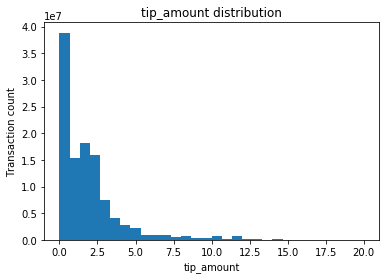

In [76]:
target = 'tip_amount'
writing_path = Path(figures_dir, 'tip_amount_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=30, range_lst=[0,20])
write_figure(target, bins, hist, writing_path)

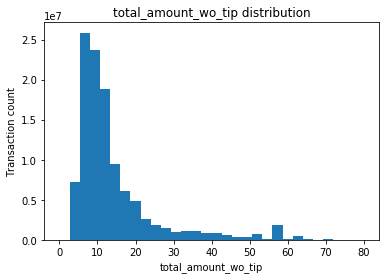

In [77]:
target = 'total_amount_wo_tip'
writing_path = Path(figures_dir, 'total_amount_wo_tip_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=30, range_lst=[0,80])
write_figure(target, bins, hist, writing_path)

In [78]:
# bins = [round(x, 2) for x in bins]
# plt.bar(range(0,30), hist_values)
# plt.xticks(range(0,30), bins, rotation='vertical')
# plt.ylabel('Transaction count')
# plt.xlabel('Total amount')
# plt.title('Total amounts distribution')
# plt.show()

These have similar distributions, perhaps there is some threshold point at which people feel more obliged to tip. There may be more signal in tip fraction

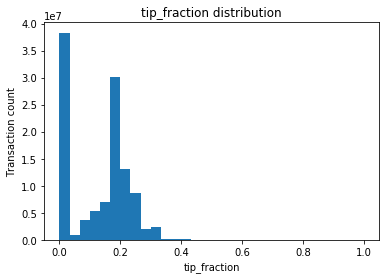

In [79]:
target = 'tip_fraction'
writing_path = Path(figures_dir, 'tip_fraction_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=30, range_lst=[0,1])
write_figure(target, bins, hist, writing_path)

Seems that the majority of riders will either tip around 20% to the driver, or not at all. Perhaps this is a reporting issue with payment types though - where credit card payments are not being recorded.  

## Seasonal trends

### Tip by location

In [83]:
pu_location = 'PULocationID'
do_location = 'DOLocationID'
# We'll use tip fraction here since it seems to give a better signal than tip amount
tip = 'tip_fraction'

In [84]:
tip_by_region = ddf.groupby(pu_location)[tip].mean()

In [85]:
tip_by_region.compute()

PULocationID
1      0.906380
10     0.161191
100    0.116176
101    0.166997
102    0.053740
         ...   
109    8.542717
110    0.102440
99     0.058358
199    0.192845
104    0.000000
Name: tip_fraction, Length: 264, dtype: float64

### Tips by day of the week

In [86]:
# Using picking time as the timestamp
ts = 'tpep_pickup_datetime'

In [87]:
%time day_of_week_tips = ddf.groupby([ddf[ts].dt.dayofweek]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 3.15 s, sys: 308 ms, total: 3.45 s
Wall time: 27.3 s


In [88]:
days_dict = {'Monday':0, 
             'Tuesday':1, 
             'Wednesday':2, 
             'Thursday':3, 
             'Friday':4, 
             'Saturday': 5, 
             'Sunday':6}

In [89]:
index_map = {y:x for x, y in days_dict.items()}
day_of_week_tips.index = day_of_week_tips.index.map(index_map)

In [90]:
print(day_of_week_tips)

                     tip_fraction                    
                             mean       std     count
tpep_pickup_datetime                                 
Monday                   0.131513  0.795732  14879162
Tuesday                  0.134655  0.622968  15986547
Wednesday                0.135222  0.769716  16182062
Thursday                 0.135341  0.677671  17174383
Friday                   0.131413  0.745635  17334732
Saturday                 0.124838  0.717446  16550357
Sunday                   0.126649  0.636842  14127383


In [91]:
print(tip)

tip_fraction


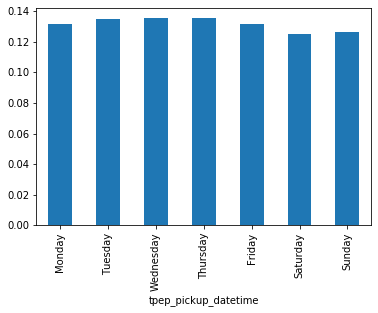

In [92]:
# import matplotlib.pyplot as plt
bar_plt = day_of_week_tips[(tip,'mean')].plot.bar()

<ErrorbarContainer object of 3 artists>

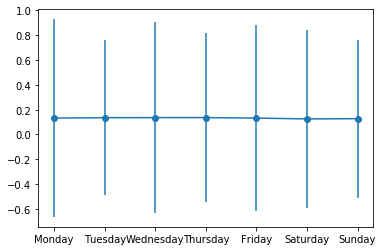

In [93]:
plt.scatter(day_of_week_tips.index, 
        day_of_week_tips[(tip,'mean')])
        
plt.errorbar(day_of_week_tips.index, 
             day_of_week_tips[(tip,'mean')],
             day_of_week_tips[(tip,'std')])

There appears to be lower tips on Saturdays. It would be interesting to compare what other factors might affect reported tips on that day

### Hourly trends during the week relative to Saturday and Sunday

In [36]:
%time monday_tips = ddf.groupby([ddf[ts].dt.dayofweek == 5]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 2.95 s, sys: 437 ms, total: 3.39 s
Wall time: 26 s


In [37]:
print(monday_tips)

                     tip_fraction                    
                             mean       std     count
tpep_pickup_datetime                                 
False                    0.132616  0.711717  95684269
True                     0.124838  0.717446  16550357


Let's look at tiping behavior over the course of the year, averaging result by day

In [38]:
%time day_mean_tips = ddf.groupby([ddf[ts].dt.date])[tip].mean().compute()

CPU times: user 10.7 s, sys: 1.25 s, total: 12 s
Wall time: 3min 47s


In [39]:
print(day_mean_tips)

tpep_pickup_datetime
2009-01-01    0.060512
2018-11-07    0.136925
2018-12-01    0.127297
2018-12-02    0.129253
2018-12-03    0.133394
                ...   
2018-11-03    0.127308
2019-11-20    0.098266
2019-11-21    0.040000
2019-01-04    0.150000
2019-01-26    0.100000
Name: tip_fraction, Length: 445, dtype: float64


In [40]:
"""
Cleanup and plot result
"""
day_mean_tips.sort_index(inplace=True)

In [41]:
import pandas as pd
# Transform indices back to datetime objects for filtering
day_mean_tips.index = pd.to_datetime(day_mean_tips.index.to_series())
# results = {index: row for index, row in day_mean_tips.iteritems() if index.year == 2018}

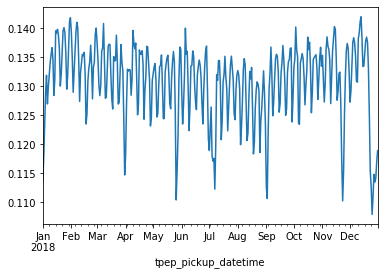

In [42]:
filtered_day_mean_tips = day_mean_tips[day_mean_tips.index.year == 2018]
filtered_day_mean_tips.plot()

#### Aggregate by week

In [43]:
%time weekly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.week]).mean()

CPU times: user 4.84 ms, sys: 584 µs, total: 5.42 ms
Wall time: 12.3 ms


(52,)


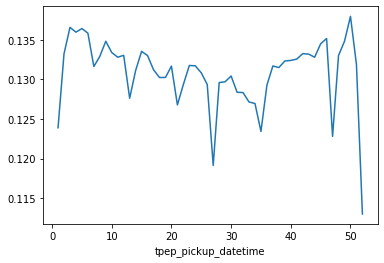

In [44]:
print(weekly_mean_tips.shape)
weekly_mean_tips.plot()

#### Aggregate by month

In [45]:
%time monthly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.month]).mean()

CPU times: user 3.8 ms, sys: 0 ns, total: 3.8 ms
Wall time: 3.15 ms


(12,)


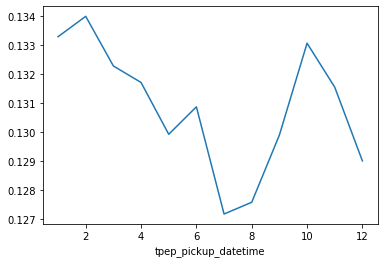

In [46]:
print(monthly_mean_tips.shape)
monthly_mean_tips.plot()

Seems there is some cyclicality to tipping (e.g., a spike in the fall/early winter months). We'd have to look at other things like the variance to gauge how meaninful this trend is. 